In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

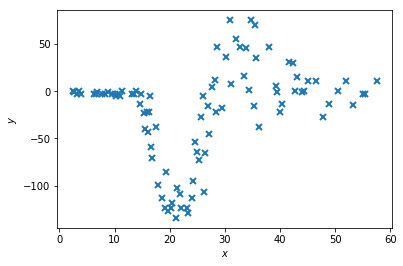

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = hetero_kernels.RBF(1)
k2 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptLAdaptN(Xnorm, Y[:,None], k1, k2, nonstat)

In [4]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V3,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.kern1.lengthscales,[ 1.],None,+ve
adapt_ll_noise_gps.kern1.variance,[ 1.],None,+ve
adapt_ll_noise_gps.kern2.lengthscales,[ 1.],None,+ve
adapt_ll_noise_gps.kern2.variance,[ 1.],None,+ve
adapt_ll_noise_gps.nonstat.signal_variance,[ 1.],None,+ve
adapt_ll_noise_gps.signal_variance,[ 1.],None,+ve


In [5]:
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern1.variance = 0.1
#m.kern1.variance.fixed = True
m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern2.variance = 0.05
m.kern2.variance.fixed = True

m.nonstat.signal_variance = 100
m.nonstat.signal_variance.fixed = True

In [6]:
m.optimize(maxiter=5000)

      fun: array([ 810.01731977])
 hess_inv: <286x286 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.08594147e-03,   5.86524551e-03,   5.71076644e-03,
         3.31435694e-03,   1.73555278e-03,   1.96532868e-03,
        -8.39029306e-04,  -7.13931201e-04,  -2.55145032e-03,
        -2.95481955e-03,  -4.74626976e-03,  -4.46425547e-03,
        -2.76741586e-03,  -2.17039298e-03,  -3.45929103e-03,
        -3.66483732e-03,  -3.61050897e-03,  -6.27089932e-03,
        -1.87593989e-03,  -1.36036367e-03,  -2.01478136e-03,
        -8.08100003e-04,  -5.84854529e-04,  -9.88096427e-05,
         1.67770679e-04,   1.83762777e-05,   2.47431985e-04,
         4.42576752e-04,   6.11755063e-04,   6.65609995e-04,
         2.12550976e-03,   1.15905666e-03,   3.00947503e-03,
         2.62447587e-03,   1.53099954e-03,   1.59795107e-03,
         3.19827389e-03,   1.95288400e-03,   4.08443379e-03,
         1.98256577e-03,   3.11582225e-03,   2.39533582e-03,
         4.46146436e-03,   1.30640625e-03

In [7]:
samples = m.sample(2000, verbose=True, epsilon=0.01, thin = 2, burn = 1000, Lmax = 40)

burn-in sampling started
Iteration:  100 	 Acc Rate:  93.0 %
Iteration:  200 	 Acc Rate:  97.0 %
Iteration:  300 	 Acc Rate:  97.0 %
Iteration:  400 	 Acc Rate:  92.0 %
Iteration:  500 	 Acc Rate:  98.0 %
Iteration:  600 	 Acc Rate:  99.0 %
Iteration:  700 	 Acc Rate:  96.0 %
Iteration:  800 	 Acc Rate:  94.0 %
Iteration:  900 	 Acc Rate:  97.0 %
Iteration:  1000 	 Acc Rate:  96.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  95.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  98.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  99.0 %
Iteration:  800 	 Acc Rate:  98.0 %
Iteration:  900 	 Acc Rate:  94.0 %
Iteration:  1000 	 Acc Rate:  96.0 %
Iteration:  1100 	 Acc Rate:  96.0 %
Iteration:  1200 	 Acc Rate:  98.0 %
Iteration:  1300 	 Acc Rate:  95.0 %
Iteration:  1400 	 Acc Rate:  93.0 %
Iteration:  1500 	 Acc Rate:  98.0 %
Iteration:  1600 	 Acc Rate:  100.0 %
Itera

In [8]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[ -8.99509354e-01] [ -8.50065830e-01] [ -3.95370885e-01] [ -2.32294530e-01] [ -8.83832367e-02] [ -9.40394655e-03] [ 7.58632710e-02] [ 4.21160274e-02] [ 8.09941033e-02] [ 6.01051765e-02] [ 8.41835103e-02] [ 5.24073303e-02] [ 7.85826763e-03] [ -3.64321887e-03] [ -2.37239546e-02] [ -4.10601611e-02] [ -5.73082308e-02] [ -1.74447772e-01] [ -1.25414380e-01] [ -1.14701248e-01] [ -2.42813944e-01] [ -1.07586962e-01] [ -2.16707203e-01] [ -1.39316654e-01] [ -1.49463101e-01] [ -1.59853997e-01] [ -1.76004946e-01] [ -1.81594098e-01] [ -1.70061048e-01] [ -1.68321889e-01] [ -3.26987163e-01] [ -1.47990587e-01] [ -3.30827063e-01] [ -3.13169815e-01] [ -1.91492776e-01] [ -1.92307175e-01] [ -3.64986315e-01] [ -2.12272619e-01] [ -3.81628112e-01] [ -1.84754669e-01] [ -2.59228357e-01] [ -2.08812545e-01] [ -4.88753581e-01] [ -1.68214825e-01] [ -3.34510893e-01] [ -2.12957603e-01] [ -2.81942570e-01] [ -2.81824367e-01] [ -2.64092909e-01] [ -1.86947456e-01] [ -2.43708753e-01] [ -1.83422187e-01] [ -1.74716936e-01] [ -3.00761112e-01] [ -1.78318818e-01] [ -2.21893532e-01] [ -2.79041175e-01] [ -1.61499798e-01] [ -1.50727595e-01] [ -3.13913708e-01] [ -2.91587336e-01] [ -2.91782591e-01] [ -1.48615742e-01] [ -3.25359545e-01] [ -3.08897573e-01] [ -2.68754728e-01] [ -2.35302401e-01] [ -3.14562966e-01] [ -2.52079916e-01] [ -2.53421258e-01] [ -1.87712799e-01] [ -1.82593838e-01] [ -3.29710064e-01] [ -5.06824548e-01] [ -4.71921888e-01] [ -1.72401881e-01] [ -3.31043496e-01] [ -2.44984064e-01] [ -3.65010250e-01] [ -2.73854601e-01] [ -1.94610907e-01] [ -1.38082046e-01] [ -2.64446278e-01] [ -1.20238360e-01] [ -1.42149627e-01] [ -1.88061786e-01] [ -1.11252765e-01] [ -7.01232709e-02] [ -5.24048348e-02] [ -2.14405211e-02] [ -7.87483234e-03] [ -3.11414422e-03] [ -6.83908672e-04] [ -7.68024250e-04]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V2,[[ 2.82282785e+00] [ 5.99756653e+00] [ 3.26458287e+00] [ 1.88724497e+00] [ 2.66522136e+00] [ 6.93660859e+00] [ 1.88712397e+00] [ 1.51141784e+00] [ 3.58707850e+00] [ 2.26653240e+00] [ 2.49274320e+00] [ 2.95383234e+00] [ 2.16396115e+00] [ 1.60590830e+00] [ 1.89006648e+00] [ 2.00550389e+00] [ 1.98254219e+00] [ 3.48386472e+00] [ 1.41045324e+00] [ 9.70934486e-01] [ 1.64077465e+00] [ 1.14875872e+00] [ 1.48742562e+00] [ 1.11233029e+00] [ 9.62355210e-01] [ 8.95795726e-01] [ 8.63587672e-01] [ 8.50753761e-01] [ 8.24514176e-01] [ 8.09864311e-01] [ 1.32340091e+00] [ 9.19911177e-01] [ 1.13256645e+00] [ 9.52487486e-01] [ 6.22269052e-01] [ 5.07092411e-01] [ 6.48347636e-01] [ 5.04860347e-01] [ 6.98754280e-01] [ 4.75782199e-01] [ 4.54760772e-01] [ 3.64591337e-01] [ 5.82617542e-01] [ 3.25171365e-01] [ 3.03532992e-01] [ 2.07476361e-01] [ 1.87798192e-01] [ 1.64736094e-01] [ 1.39774850e-01] [ 1.03966080e-01] [ 8.94324651e-02] [ 6.78517104e-02] [ 4.48073175e-02] [ 2.56291790e-02] [ 1.11952354e-02] [ -8.64466722e-03] [ -4.19806842e-02] [ -4.10713794e-02] [ -4.08349918e-02] [ -1.10918169e-01] [ -1.58197402e-01] [ -1.83155998e-01] [ -1.26683205e-01] [ -2.00640729e-01] [ -2.42223469e-01] [ -2.25970738e-01] [ -1.90437953e-01] [ -2.16476556e-01] [ -1.88685624e-01] [ -1.87968194e-01] [ -1.48389445e-01] [ -1.42379311e-01] [ -1.95164530e-01] [ -3.60937670e-01] [ -2.52631230e-01] [ -1.21845713e-01] [ -1.37931379e-01] [ -1.27749704e-01] [ -1.99640469e-01] [ -1.54884440e-01] [ -1.02956978e-01] [ -7.40407258e-02] [ -1.11608972e-01] [ -7.99491632e-02] [ -7.56659135e-02] [ -1.00693314e-01] [ -6.70412898e-02] [ -4.74955732e-02] [ -4.56861046e-02] [ -2.56521406e-02] [ -1.50962624e-02] [ -1.02429822e-02] [ -3.54580993e-03] [ -2.58636281e-03]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V3,[[-0.06929909] [-0.21852824] [-0.07200849] [-0.10300934] [-0.07680697] [-0.09178858] [-0.11377739] [-0.09053478] [-0.04172858] [-0.12386371] [-0.25582525] [-0.20470205] [-0.00927253] [ 0.05899267] [ 0.04466941] [ 0.01955291] [-0.00758817] [-0.31118619] [-0.98553217] [-1.64682193] [-2.71102627] [-3.2145386 ] [-3.82031052] [-3.47530574] [-2.70

In [9]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv

In [10]:
sample_df = m.get_samples_df(samples)

In [11]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [12]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [13]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [14]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [15]:
def visualize(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

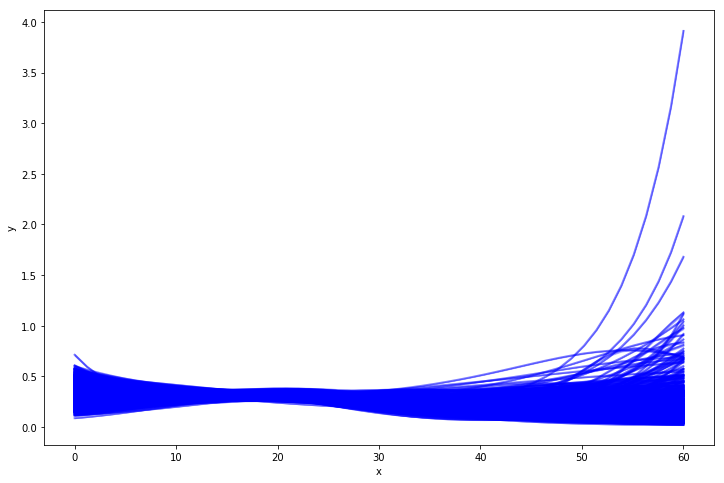

In [16]:
mini = 505
maxi = 1110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [17]:
mean_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [18]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_n(xx)
    var1 = v1[:,:]
    mean_n_mat[i,:] = mean1[:,0]
    var_n_mat[i,:] = np.diag(var1)

std_n_mat = np.sqrt(var_n_mat)

In [19]:
LowerlogN = mean_n_mat - 2*std_n_mat
UpperlogN = mean_n_mat + 2*std_n_mat

In [20]:
MeanN = np.exp(mean_n_mat)
LowerN = np.exp(LowerlogN)
UpperN = np.exp(UpperlogN)

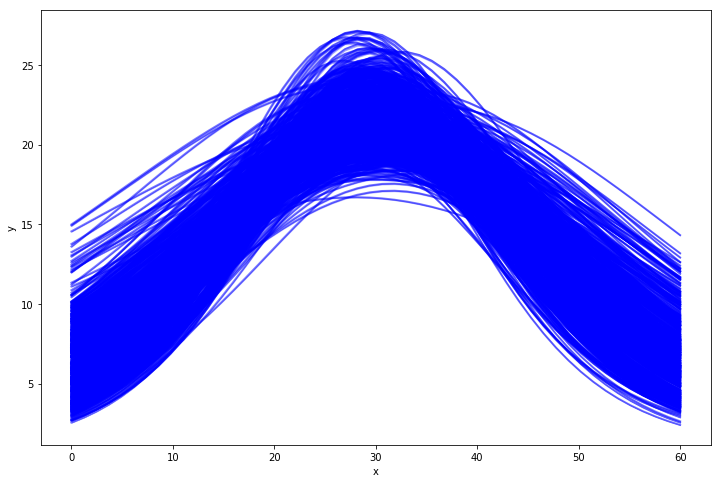

In [21]:
mini = 500
maxi = 1110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanN[i,:], LowerN[i,:], UpperN[i,:])  

In [22]:
sig_samples = m.signal_variance.get_samples_df(samples)
signal_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

In [23]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)    

In [24]:
std_f_mat = np.sqrt(var_f_mat)

In [25]:
Lowerf = mean_f_mat - 2*std_f_mat
Upperf = mean_f_mat + 2*std_f_mat

In [26]:
def visualize_all(Xgrid, M1, L1, U1, U2, signal_var):
    """
    Visualize
    """  
    L2 = L1 - U2
    U2 = U1 + U2
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

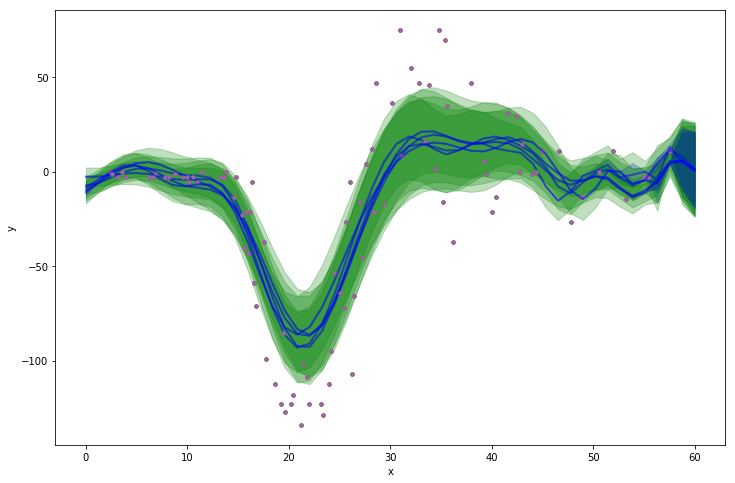

In [27]:
mini = 300
maxi = 305
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_all(xnew, mean_f_mat[i,:],
              Lowerf[i,:], Upperf[i,:],
              UpperN[i,:], signal_var[i])

In [28]:
signal_var

array([ 0.32482148,  0.50418186,  0.59779553, ...,  7.6173334 ,
        7.20867014,  6.8794249 ])